# TensorFlow Hub

Using models others have made and applying it our dataset

- https://tfhub.dev/

### Getting Started

Dataset:
- https://www.kaggle.com/datasets/gpiosenka/balls-image-classification

### Batching the Data

```
train_dir = 'train/'
test_dir = 'test/'

train_data = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=(224,224)
)

test_data = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(224,224)
)

train_data = train_data.cache().prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(tf.data.AUTOTUNE)

```

### Training the Model

```
model_1 = tf.keras.Sequential()

model_1.add(tf.keras.layers.Rescaling(1./255))

model_1.add(
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
                   trainable=False),  # Can be True, see below.
    
)

model_1.add(tf.keras.layers.Dense(26, activation='softmax'))

model_1.build([None, 224, 224, 3])  # Batch input shape.

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

```

### Predictions

```
y_true = []
preds = []

def predictor(path, image):
  target = path + '/' + image
  category = path.split('/')[1]

  img = tf.io.read_file(target)
  img = tf.io.decode_file(img)
  img = tf.image.resize(img, [224,224])
  img = img/255.
  img = tf.expand_dims(img, axis=0)
  pred = np.argmax(model_1.predict(img), axis=1)
  preds.append(pred[0])

  y_true.append(class_names[category])

for dirs, fols, files in os.walk('test'):
  if len(fols) < 1:
    for file in files:
      predictor(dirs, file)

print(classification_report(y_true, preds))
sns.heatmap(confusion_matrix(y_true, preds), annot=True)
```



### Import the Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import tensorflow as tf

import tensorflow_hub as hub

import os
import random

from zipfile import ZipFile

from sklearn.metrics import confusion_matrix, classification_report

### Connect to Kaggle, Download and unzip the dataset

- Explore the data

In [1]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d gpiosenka/balls-image-classification

100% 183M/183M [00:04<00:00, 42.4MB/s]
100% 183M/183M [00:04<00:00, 39.4MB/s]


In [5]:
uz = ZipFile('balls-image-classification.zip')
uz.extractall()
uz.close()

In [7]:
total=0

for dirs, fols, files in os.walk('train'):
  print(f'{dirs}, {len(fols)}, {len(files)}')
  if len(fols) < 1:
    total += len(files)

print(f'total files {total}')

train, 26, 0
train/pokeman balls, 0, 86
train/baseball, 0, 112
train/tennis ball, 0, 139
train/volley ball, 0, 131
train/meat ball, 0, 137
train/marble, 0, 131
train/paint balls, 0, 32
train/golf ball, 0, 106
train/medicine ball, 0, 77
train/football, 0, 112
train/brass, 0, 113
train/bowling ball, 0, 145
train/eyeballs, 0, 139
train/cannon ball, 0, 183
train/water polo ball, 0, 139
train/basketball, 0, 116
train/soccer ball, 0, 167
train/billiard ball, 0, 143
train/puffballs, 0, 106
train/screwballs, 0, 140
train/cricket ball, 0, 150
train/wrecking ball, 0, 69
train/beachballs, 0, 92
train/wiffle ball, 0, 99
train/tether ball, 0, 105
train/buckeyballs, 0, 82
total files 3051


In [8]:
print(3051/26)

117.34615384615384


(224, 224, 3)


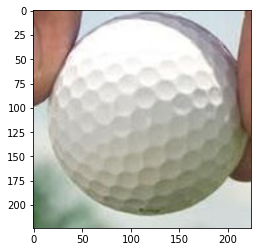

In [13]:
path = 'train/'
category = 'golf ball/'
target = path + category

image = random.choice(os.listdir(target))

img = mpimage.imread(target + image)
print(img.shape)

plt.imshow(img)

### Batch and Normalize the Data

- Get the class_names and create a dictionary
- Optional: Prefetch the data


In [14]:
# I want to show 2 ways to batch and normalize the data

train_dir = 'train/'
test_dir = 'test/'



In [18]:
# Flow from directory with rescaling - ImageDataGenerator

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_ff = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='categorical'
)

test_data_ff = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    class_mode='categorical'
)

Found 3051 images belonging to 26 classes.
Found 130 images belonging to 26 classes.


In [38]:
# Image_dataset_from_directory

train_data_img = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224,224),
    label_mode='categorical'
)


test_data_img = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224,224),
    label_mode='categorical'
)

train_data_img = train_data_img.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_img = test_data_img.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 3051 files belonging to 26 classes.
Found 130 files belonging to 26 classes.


In [19]:
# With image_dataset_from_directory and prefetching we lost class_indices

train_data_ff.class_indices

{'baseball': 0,
 'basketball': 1,
 'beachballs': 2,
 'billiard ball': 3,
 'bowling ball': 4,
 'brass': 5,
 'buckeyballs': 6,
 'cannon ball': 7,
 'cricket ball': 8,
 'eyeballs': 9,
 'football': 10,
 'golf ball': 11,
 'marble': 12,
 'meat ball': 13,
 'medicine ball': 14,
 'paint balls': 15,
 'pokeman balls': 16,
 'puffballs': 17,
 'screwballs': 18,
 'soccer ball': 19,
 'tennis ball': 20,
 'tether ball': 21,
 'volley ball': 22,
 'water polo ball': 23,
 'wiffle ball': 24,
 'wrecking ball': 25}

In [20]:
train_data_img.class_names

['baseball',
 'basketball',
 'beachballs',
 'billiard ball',
 'bowling ball',
 'brass',
 'buckeyballs',
 'cannon ball',
 'cricket ball',
 'eyeballs',
 'football',
 'golf ball',
 'marble',
 'meat ball',
 'medicine ball',
 'paint balls',
 'pokeman balls',
 'puffballs',
 'screwballs',
 'soccer ball',
 'tennis ball',
 'tether ball',
 'volley ball',
 'water polo ball',
 'wiffle ball',
 'wrecking ball']

In [21]:
class_indices = dict(zip(
    test_data_img.class_names,
    np.arange(len(test_data_img.class_names))
))

In [22]:
class_indices

{'baseball': 0,
 'basketball': 1,
 'beachballs': 2,
 'billiard ball': 3,
 'bowling ball': 4,
 'brass': 5,
 'buckeyballs': 6,
 'cannon ball': 7,
 'cricket ball': 8,
 'eyeballs': 9,
 'football': 10,
 'golf ball': 11,
 'marble': 12,
 'meat ball': 13,
 'medicine ball': 14,
 'paint balls': 15,
 'pokeman balls': 16,
 'puffballs': 17,
 'screwballs': 18,
 'soccer ball': 19,
 'tennis ball': 20,
 'tether ball': 21,
 'volley ball': 22,
 'water polo ball': 23,
 'wiffle ball': 24,
 'wrecking ball': 25}

### Model 1 - Create a Model with EfficientNetB0

- Setup the TFHub EfficientNetB0 Model
- Get a summary of the model
- Compile the model
- Fit the model for 5 epochs

In [25]:
model_1 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(26, activation='softmax')
])
model_1.build([None, 224, 224, 3])  # Batch input shape.

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 28s 87ms/step - loss: 1735.6097 - accuracy: 0.0587 - val_loss: 1492.0793 - val_accuracy: 0.0615
Epoch 2/5
96/96 [==============================] - 7s 71ms/step - loss: 1160.0522 - accuracy: 0.0914 - val_loss: 1295.9504 - val_accuracy: 0.0538
Epoch 3/5
96/96 [==============================] - 7s 71ms/step - loss: 905.0039 - accuracy: 0.1252 - val_loss: 1337.5396 - val_accuracy: 0.0462
Epoch 4/5
96/96 [==============================] - 7s 70ms/step - loss: 816.3314 - accuracy: 0.1481 - val_loss: 1233.7668 - val_accuracy: 0.0615
Epoch 5/5
96/96 [==============================] - 7s 71ms/step - loss: 694.5344 - accuracy: 0.1708 - val_loss: 1225.5054 - val_accuracy: 0.0385


In [24]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4049564   
                                                                 
 dense (Dense)               (None, 26)                33306     
                                                                 
Total params: 4,082,870
Trainable params: 33,306
Non-trainable params: 4,049,564
_________________________________________________________________


In [26]:
model_1 = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
                   trainable=False),  # Can be True, see below.
    tf.keras.layers.Dense(26, activation='softmax')
])
model_1.build([None, 224, 224, 3])  # Batch input shape.

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_data_ff,
    validation_data=test_data_ff,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 18s 95ms/step - loss: 1.1763 - accuracy: 0.7745 - val_loss: 0.3803 - val_accuracy: 0.9462
Epoch 2/5
96/96 [==============================] - 8s 79ms/step - loss: 0.2840 - accuracy: 0.9515 - val_loss: 0.2083 - val_accuracy: 0.9769
Epoch 3/5
96/96 [==============================] - 8s 79ms/step - loss: 0.1690 - accuracy: 0.9715 - val_loss: 0.1512 - val_accuracy: 0.9846
Epoch 4/5
96/96 [==============================] - 8s 78ms/step - loss: 0.1166 - accuracy: 0.9843 - val_loss: 0.1200 - val_accuracy: 0.9769
Epoch 5/5
96/96 [==============================] - 8s 78ms/step - loss: 0.0861 - accuracy: 0.9902 - val_loss: 0.1074 - val_accuracy: 0.9846


### Model 2 - EfficientNet Add A Rescaling Layer and Dense Fully Connected Layer

- Break out the KerasLayer and add it to the Sequential model
- Add a Rescaling Layer between the Sequential Layer and the KerasLayer
- Add a Fully connected Dense layer with 1000 units after the Keras Layer
- Create the output Layer
- Build the model and look at the summary
- Compile and Fit the model for 5 epochs

In [30]:
model_2 = tf.keras.Sequential()

# Rescaling Layer
model_2.add(tf.keras.layers.Rescaling(scale=1./255))

model_2.add(hub.KerasLayer(
    "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
     trainable=False))

model_2.add(tf.keras.layers.Dense(26, activation='softmax'))

model_2.build([None, 224, 224, 3])  # Batch input shape.

model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2 = model_2.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 15s 80ms/step - loss: 1.2055 - accuracy: 0.7630 - val_loss: 0.4016 - val_accuracy: 0.9231
Epoch 2/5
96/96 [==============================] - 7s 71ms/step - loss: 0.2834 - accuracy: 0.9544 - val_loss: 0.2148 - val_accuracy: 0.9692
Epoch 3/5
96/96 [==============================] - 7s 71ms/step - loss: 0.1688 - accuracy: 0.9738 - val_loss: 0.1542 - val_accuracy: 0.9769
Epoch 4/5
96/96 [==============================] - 9s 87ms/step - loss: 0.1167 - accuracy: 0.9839 - val_loss: 0.1260 - val_accuracy: 0.9846
Epoch 5/5
96/96 [==============================] - 7s 70ms/step - loss: 0.0860 - accuracy: 0.9908 - val_loss: 0.1101 - val_accuracy: 0.9846


In [28]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_3 (Dense)             (None, 26)                33306     
                                                                 
Total params: 4,082,870
Trainable params: 33,306
Non-trainable params: 4,049,564
_________________________________________________________________


In [29]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_2 (Dense)             (None, 26)                33306     
                                                                 
Total params: 4,082,870
Trainable params: 33,306
Non-trainable params: 4,049,564
_________________________________________________________________


### Model 3 - Create a Model with ResNet50V2

- Setup the TFHub ResNet50V2 Model
- Get a summary of the model
- Compile the model
- Fit the model for 5 epochs

In [33]:
model_3 = tf.keras.Sequential()



model_3.add(hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
    trainable=False))

model_3.add(tf.keras.layers.Dense(26, activation='softmax'))

model_3.build([None, 224, 224, 3])  # Batch input shape.

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3 = model_3.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 15s 112ms/step - loss: 109.2570 - accuracy: 0.1147 - val_loss: 50.0460 - val_accuracy: 0.2154
Epoch 2/5
96/96 [==============================] - 9s 95ms/step - loss: 48.9994 - accuracy: 0.2429 - val_loss: 51.3581 - val_accuracy: 0.2769
Epoch 3/5
96/96 [==============================] - 9s 95ms/step - loss: 38.6381 - accuracy: 0.3058 - val_loss: 59.2096 - val_accuracy: 0.2385
Epoch 4/5
96/96 [==============================] - 9s 94ms/step - loss: 37.1600 - accuracy: 0.3412 - val_loss: 33.3425 - val_accuracy: 0.4385
Epoch 5/5
96/96 [==============================] - 9s 95ms/step - loss: 29.3735 - accuracy: 0.4022 - val_loss: 44.0896 - val_accuracy: 0.3462


In [32]:
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_5 (Dense)             (None, 26)                53274     
                                                                 
Total params: 23,618,074
Trainable params: 53,274
Non-trainable params: 23,564,800
_________________________________________________________________


In [34]:
model_3 = tf.keras.Sequential()

model_3.add(tf.keras.layers.Rescaling(scale=1./255))

model_3.add(hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
    trainable=False))

model_3.add(tf.keras.layers.Dense(26, activation='softmax'))

model_3.build([None, 224, 224, 3])  # Batch input shape.

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3 = model_3.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 13s 100ms/step - loss: 0.9381 - accuracy: 0.7535 - val_loss: 0.2338 - val_accuracy: 0.9385
Epoch 2/5
96/96 [==============================] - 9s 95ms/step - loss: 0.1778 - accuracy: 0.9571 - val_loss: 0.1556 - val_accuracy: 0.9615
Epoch 3/5
96/96 [==============================] - 9s 96ms/step - loss: 0.0995 - accuracy: 0.9813 - val_loss: 0.1219 - val_accuracy: 0.9615
Epoch 4/5
96/96 [==============================] - 9s 96ms/step - loss: 0.0654 - accuracy: 0.9912 - val_loss: 0.1106 - val_accuracy: 0.9615
Epoch 5/5
96/96 [==============================] - 9s 96ms/step - loss: 0.0447 - accuracy: 0.9951 - val_loss: 0.0996 - val_accuracy: 0.9692


### Model 4 - Create a Model with InceptionResNetV2

- Setup the TFHub IncetpionsResNetV2 Model
- Get a summary of the model
- Compile the model
- Fit the model for 5 epochs

In [35]:
model_4 = tf.keras.Sequential()

model_4.add(tf.keras.layers.Rescaling(scale=1./255))

model_4.add(hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
    trainable=False))

model_4.add(tf.keras.layers.Dense(26, activation='softmax'))
model_4.build([None, 299, 299, 3])  # Batch input shape.

model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4 = model_4.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 38s 236ms/step - loss: 0.8551 - accuracy: 0.7686 - val_loss: 0.2838 - val_accuracy: 0.9231
Epoch 2/5
96/96 [==============================] - 19s 195ms/step - loss: 0.2952 - accuracy: 0.9131 - val_loss: 0.1879 - val_accuracy: 0.9462
Epoch 3/5
96/96 [==============================] - 19s 198ms/step - loss: 0.2134 - accuracy: 0.9394 - val_loss: 0.1508 - val_accuracy: 0.9692
Epoch 4/5
96/96 [==============================] - 19s 197ms/step - loss: 0.1623 - accuracy: 0.9554 - val_loss: 0.1353 - val_accuracy: 0.9538
Epoch 5/5
96/96 [==============================] - 19s 195ms/step - loss: 0.1344 - accuracy: 0.9656 - val_loss: 0.1456 - val_accuracy: 0.9462


In [36]:
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 keras_layer_8 (KerasLayer)  (None, 1536)              54336736  
                                                                 
 dense_8 (Dense)             (None, 26)                39962     
                                                                 
Total params: 54,376,698
Trainable params: 39,962
Non-trainable params: 54,336,736
_________________________________________________________________


In [40]:
model_4 = tf.keras.Sequential()

model_4.add(tf.keras.layers.Rescaling(scale=1./255))

model_4.add(hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5",
    trainable=False))

model_4.add(tf.keras.layers.Dense(26, activation='softmax'))
model_4.build([None, 299, 299, 3])  # Batch input shape.

model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4 = model_4.fit(
    train_data_img,
    validation_data=test_data_img,
    epochs=5
)

Epoch 1/5
96/96 [==============================] - 35s 219ms/step - loss: 0.9166 - accuracy: 0.7496 - val_loss: 0.2573 - val_accuracy: 0.9308
Epoch 2/5
96/96 [==============================] - 18s 188ms/step - loss: 0.2903 - accuracy: 0.9112 - val_loss: 0.1881 - val_accuracy: 0.9538
Epoch 3/5
96/96 [==============================] - 18s 184ms/step - loss: 0.2084 - accuracy: 0.9407 - val_loss: 0.1588 - val_accuracy: 0.9462
Epoch 4/5
96/96 [==============================] - 18s 184ms/step - loss: 0.1639 - accuracy: 0.9554 - val_loss: 0.1438 - val_accuracy: 0.9538
Epoch 5/5
96/96 [==============================] - 18s 185ms/step - loss: 0.1352 - accuracy: 0.9643 - val_loss: 0.1350 - val_accuracy: 0.9538


In [39]:
train_data_img

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26), dtype=tf.float32, name=None))>